(inverse_dynamics)=
## Inverse dynamics
Each manoeuvring model has some hydrodynamic functions $X_D(u,v,r,\delta,thrust)$, $Y_D(u,v,r,\delta,thrust)$, $N_D(u,v,r,\delta,thrust)$ that are defined as polynomials. 

The hydrodynamic derivatives in these polynomials can be identified with force regression of measured forces and moments. The measured forces and moments are usually taken from captive model tests, PMM tests or Virtual Captive Tests (VCT) being the virtual version of captive/PMM tests calculated with Computational Fluid Dynamics (CFD). 

When the ship or ship model is free in all degrees of freedome, as in the present model tests, only motions can be observed however. The forces and moments that generated the motions needs to be estimated by solving the inverse dynamics problem and doing a motion regression. 

In [1]:
# %load imports.py
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)
%matplotlib inline

import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

import pandas as pd
from src.models.vmm import ModelSimulator
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('paper')
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"]})

#matplotlib.rcParams["xtick.labelsize"] = 16
from src.visualization.plot import track_plots, plot, captive_plot
import kedro
import numpy as np
import os.path
import anyconfig


from myst_nb import glue
from src.symbols import *
import src.symbols as symbols
from src.system_equations import *

from IPython.display import display, Math, Latex, Markdown
from sympy.physics.vector.printing import vpprint, vlatex

from src.models.regression import MotionRegression, Regression

from src.parameters import df_parameters
from src.substitute_dynamic_symbols import run
from src.models.diff_eq_to_matrix import DiffEqToMatrix
p = df_parameters["symbol"]
import statsmodels.api as sm

from src.models.force_from_motion import predict_force

# Read configs:
conf_path = os.path.join("../../conf/base/")
runs_globals_path = os.path.join(
    conf_path,
    "runs_globals.yml",
)

runs_globals = anyconfig.load(runs_globals_path)
model_test_ids = runs_globals["model_test_ids"]

join_globals_path = os.path.join(
    conf_path,
    "join_globals.yml",
)

joins = runs_globals["joins"]
join_runs_dict = anyconfig.load(join_globals_path)

globals_path = os.path.join(
    conf_path,
    "globals.yml",
)
global_variables = anyconfig.load(globals_path)



vmm_names = global_variables["vmms"]

vmms = {}
for vmm_name in vmm_names:
    vmms[vmm_name] = catalog.load(vmm_name)

from myst_nb import glue

<>:8: DeprecationWarning: invalid escape sequence \.
<>:8: DeprecationWarning: invalid escape sequence \.
<>:8: DeprecationWarning: invalid escape sequence \.
C:\Users\maa\AppData\Local\Temp/ipykernel_14428/1892923082.py:8: DeprecationWarning: invalid escape sequence \.
  warnings.filterwarnings( "ignore", module = "matplotlib\..*" )


2022-05-09 08:31:07,089 - kedro.io.data_catalog - INFO - Loading data from `vmm_abkowitz` (PickleDataSet)...
2022-05-09 08:31:07,267 - kedro.io.data_catalog - INFO - Loading data from `vmm_linear` (PickleDataSet)...
2022-05-09 08:31:07,314 - kedro.io.data_catalog - INFO - Loading data from `vmm_martins_simple` (PickleDataSet)...


In [2]:
%reload_kedro
ship = 'wpcc'
vmm_name = 'vmm_martins_simple'
vmm = vmms[vmm_name]
data = catalog.load("wpcc.22774.data")
added_masses = catalog.load(f"{ship}.added_masses")
model = catalog.load(f"{ship}.updated.{ vmm_name}.joined.model")
initial_parameters = catalog.load(f"{ship}.initial_parameters")
#model.parameters=initial_parameters
ship_data = catalog.load(f"{ship}.ship_data")


2022-05-09 08:31:07,739 - kedro.framework.session.store - INFO - `read()` not implemented for `SQLiteStore`. Assuming empty store.
2022-05-09 08:31:13,569 - root - INFO - ** Kedro project wPCC_pipeline
2022-05-09 08:31:13,570 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-05-09 08:31:13,579 - root - INFO - Registered line magic `run_viz`
2022-05-09 08:31:13,580 - kedro.io.data_catalog - INFO - Loading data from `wpcc.22774.data` (CSVDataSet)...
2022-05-09 08:31:13,737 - kedro.io.data_catalog - INFO - Loading data from `wpcc.added_masses` (YAMLDataSet)...
2022-05-09 08:31:13,739 - kedro.io.data_catalog - INFO - Loading data from `wpcc.updated.vmm_martins_simple.joined.model` (PickleDataSet)...
2022-05-09 08:31:13,746 - kedro.io.data_catalog - INFO - Loading data from `wpcc.initial_parameters` (YAMLDataSet)...
2022-05-09 08:31:13,750 - kedro.io.data_catalog - INFO - Loading data from `wpcc.ship_data` (YAMLDataSet)...


In [3]:
glue("eqsystem", eq_system)

Eq(Matrix([
[-X_{\dot{u}} + m,                    0,                    0],
[               0,     -Y_{\dot{v}} + m, -Y_{\dot{r}} + m*x_G],
[               0, -N_{\dot{v}} + m*x_G,    I_z - N_{\dot{r}}]])*Matrix([
[\dot{u}],
[\dot{v}],
[\dot{r}]]), Matrix([
[m*r**2*x_G + m*r*v + X_D(u, v, r, delta, thrust)],
[            -m*r*u + Y_D(u, v, r, delta, thrust)],
[        -m*r*u*x_G + N_D(u, v, r, delta, thrust)]]))

In [17]:
solution = sp.solve(eq_system.doit(),X_D,Y_D,N_D, dict=True)[0]

eq_XD = sp.Eq(X_D, solution[X_D])
eq_YD = sp.Eq(Y_D, solution[Y_D])
eq_ND = sp.Eq(N_D, solution[N_D])

glue("eqxd", eq_XD)
glue("eqyd", eq_YD)
glue("eqnd", eq_ND)

Eq(X_D(u, v, r, delta, thrust), -X_{\dot{u}}*\dot{u} + \dot{u}*m - m*r**2*x_G - m*r*v)

Eq(Y_D(u, v, r, delta, thrust), -Y_{\dot{r}}*\dot{r} - Y_{\dot{v}}*\dot{v} + \dot{r}*m*x_G + \dot{v}*m + m*r*u)

Eq(N_D(u, v, r, delta, thrust), I_z*\dot{r} - N_{\dot{r}}*\dot{r} - N_{\dot{v}}*\dot{v} + \dot{v}*m*x_G + m*r*u*x_G)

The inverse dynamics is solved by restructering the system equation [eq](eqsystem) to get the hydrodynamics functions on the left hand side [eq](eqxd), [eq](eqyd), [eq](eqnd). If the mass and intertia of the ship as well as added masses: $\dot{u}$, $\dot{v}$, $\dot{r}$ are known, the forces can be calculated using these equations.

```{glue:math} eqsystem
:label: eqsystem
```

```{glue:math} eqxd
:label: eqxd
```

```{glue:math} eqyd
:label: eqyd
```

```{glue:math} eqnd
:label: eqnd
```
An example of forces calculated with inverse dynamics from motions in a turning circle test can be seen in [fig](fig_inverse).

In [6]:
subs = [(value, key ) for key,value in p.items()]
subs.append((u1d,'u1d'))
subs.append((v1d,'v1d'))
subs.append((r1d,'r1d'))

eq = eq_XD.subs(subs)
lambda_X_D = sp.lambdify(list(eq.rhs.free_symbols), eq.rhs)

eq = eq_YD.subs(subs)
lambda_Y_D = sp.lambdify(list(eq.rhs.free_symbols), eq.rhs)

eq = eq_ND.subs(subs)
lambda_N_D = sp.lambdify(list(eq.rhs.free_symbols), eq.rhs)

In [7]:
result = model.simulate(data)
df_sim = result.result

In [8]:
df_captive = df_sim.copy()
df_captive_prime = model.prime_system.prime(df_captive, U=df_sim['U'])

df_captive_prime['fx'] = run(lambda_X_D, 
                             inputs=df_captive_prime, 
                             **model.ship_parameters_prime, 
                             **added_masses)

df_captive_prime['fy'] = run(lambda_Y_D, 
                             inputs=df_captive_prime, 
                             **model.ship_parameters_prime, 
                             **added_masses)

df_captive_prime['mz'] = run(lambda_N_D, 
                             inputs=df_captive_prime, 
                             **model.ship_parameters_prime, 
                             **added_masses)

df_captive_forces = model.prime_system.unprime(df_captive_prime, U=df_sim['U'])


2022-05-09 08:31:20,359 - matplotlib.font_manager - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2022-05-09 08:31:20,360 - matplotlib.font_manager - WARNING - findfont: Generic family 'serif' not found because none of the following families were found: Times
2022-05-09 08:31:20,598 - matplotlib.font_manager - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2022-05-09 08:31:20,599 - matplotlib.font_manager - WARNING - findfont: Generic family 'serif' not found because none of the following families were found: Times


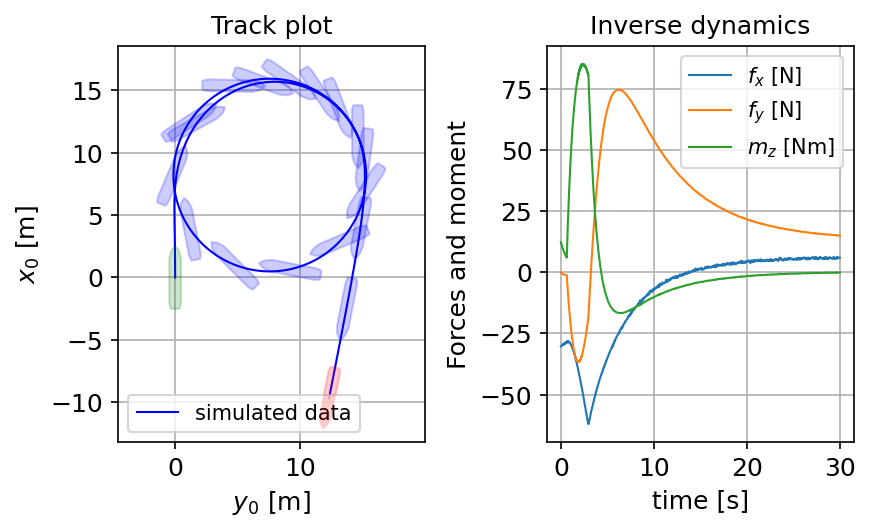

In [9]:
fig,axes=plt.subplots(ncols=2)


track_plots({'simulated data':df_sim}, lpp=ship_data['L'], beam=ship_data['B'], ax=axes[0]);

df_captive_forces.loc[0:30].plot(y=['fx','fy','mz'], label=[r'$f_x$ [N]',r'$f_y$ [N]',r'$m_z$ [Nm]'], ax=axes[1]);
axes[0].set_ylabel('$x_0$ [m]')
axes[0].set_xlabel('$y_0$ [m]');
axes[1].set_ylabel('Forces and moment')
axes[1].set_xlabel('time [s]');
axes[1].set_title('Inverse dynamics')
axes[1].grid(True)
plt.tight_layout()

glue("fig_inverse", fig, display=False);


```{glue:figure} fig_inverse
:figwidth: 1000px
:name: "fig_inverse"

Example of forces and moments calculated with inverse dynamics on data from a turning circle test.
```

## Regression

Finding the the hydrodynamic derivatives can be defined as a linear regression problem:

```{math}
:label: eqregression
y = X\beta + \epsilon
```


$$ y = X\beta + \epsilon $$

In [18]:
glue("eqxqsmodel", vmm.X_qs_eq)
glue("eqyqsmodel", vmm.Y_qs_eq)
vmm.N_qs_eq = vmm.N_qs_eq.subs([(p.Nthrust,0),(p.Ythrust,0)])  # (Twin screw)
glue("eqnqsmodel", vmm.N_qs_eq)


Eq(X_D(u, v, r, delta, thrust), X_{deltadelta}*delta**2 + X_{rr}*r**2 + X_{thrust}*thrust + X_{u}*u + X_{vr}*r*v)

Eq(Y_D(u, v, r, delta, thrust), Y_{delta}*delta + Y_{r}*r + Y_{thrustdelta}*delta*thrust + Y_{ur}*r*u + Y_{u}*u + Y_{v}*v)

Eq(N_D(u, v, r, delta, thrust), N_{delta}*delta + N_{r}*r + N_{thrustdelta}*delta*thrust + N_{ur}*r*u + N_{u}*u + N_{v}*v)

A model for the hydrodynamic forces first needs to be assumed for instance as the polynomials in: [eq](eqxqsmodel), [eq](eqyqsmodel) and [eq](eqnqsmodel).

```{glue:math} eqxqsmodel
:label: eqxqsmodel
```

```{glue:math} eqyqsmodel
:label: eqyqsmodel
```

```{glue:math} eqnqsmodel
:label: eqnqsmodel
```

In [11]:
Y_D_ = sp.symbols('Y_D')
eq = vmm.Y_qs_eq.subs(Y_D,Y_D_)
diff_eq_Y = DiffEqToMatrix(eq, label=Y_D_, base_features=[u,v,r,delta,thrust])

X_Y,y_Y = diff_eq_Y.calculate_features_and_label(data=df_captive_prime, y=df_captive_prime['fy'])

model_Y = sm.OLS(y_Y, X_Y)
result_Y = model_Y.fit()

e:\dev\wpcc\src\models\diff_eq_to_matrix.py:63: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.exclude_parameters = pd.Series(exclude_parameters)


In [12]:
N_D_ = sp.symbols('N_D')
eq = vmm.N_qs_eq.subs(N_D,N_D_)
diff_eq_N = DiffEqToMatrix(eq, label=N_D_, base_features=[u,v,r,delta,thrust])

X_N,y_N = diff_eq_N.calculate_features_and_label(data=df_captive_prime, y=df_captive_prime['mz'])

model_N = sm.OLS(y_N, X_N)
result_N = model_N.fit()

In [13]:
X_D_ = sp.symbols('X_D')
eq = vmm.X_qs_eq.subs(X_D,X_D_)
diff_eq_X = DiffEqToMatrix(eq, label=X_D_, base_features=[u,v,r,delta,thrust], exclude_parameters={'Xthrust':model.parameters['Xthrust']})

X_X,y_X = diff_eq_X.calculate_features_and_label(data=df_captive_prime, y=df_captive_prime['fx'])

model_X = sm.OLS(y_X, X_X)
result_X = model_X.fit()

The label vector $y$ and feature matrix $X$ in the regression problem in [eq](eqregression) can now be inserted. As an example the regression in surge degree of freedome the labels can be calculated using the inverse dynamics force:

```{glue:math} diff_eq_X_y
:label: diff_eq_X_y
```
And the feature matrix $X$ is expressed as:

```{glue:math} diff_eq_X_X
:label: diff_eq_X_X
```

And the regressed hydrodynamic derivatives are stored in the $\beta$ vector:

```{glue:math} diff_eq_X_beta
:label: diff_eq_X_beta
```

In [30]:
glue("diff_eq_X_y", diff_eq_X.eq_y.subs("X_D", eq_XD.rhs))

Eq(y, -X_{\dot{u}}*\dot{u} + \dot{u}*m - m*r**2*x_G - m*r*v)

In [31]:
glue("diff_eq_X_X", diff_eq_X.eq_X)

Eq(X, Matrix([[thrust, u, delta**2, r**2, r*v]]))

In [32]:
glue("diff_eq_X_beta", diff_eq_X.eq_beta)

Eq(beta, Matrix([
[    X_{thrust}],
[         X_{u}],
[X_{deltadelta}],
[        X_{rr}],
[        X_{vr}]]))

Solving the regressions with OLS in each degree of freedome gives a perfect match of hydrodynamic derivatives compared to the real model used when generating the simulated data as seen in [fig](fig_bar_parameters). Parameter identification using linear regression with forces calculated with inverse dynamics with a model that is perfectly correct on data that is also perfect will obviously give a perfect identification of the system.

In [33]:
df_parameters_X = pd.DataFrame(pd.Series({key:value for key,value in model.parameters.items() if key[0]=='X' and value !=0}, name='real'))
df_parameters_X['regression'] = result_X.params
df_parameters_X.dropna(inplace=True)
df_parameters_X.index = p[df_parameters_X.index].apply(lambda x: "$%s$" % str(x).replace('delta',r'\delta'))
df_parameters_X.index.name = ''

df_parameters_Y = pd.DataFrame(pd.Series({key:value for key,value in model.parameters.items() if key[0]=='Y' and value !=0}, name='real'))
df_parameters_Y['regression'] = result_Y.params
df_parameters_Y.dropna(inplace=True)
df_parameters_Y.index = p[df_parameters_Y.index].apply(lambda x: "$%s$" % str(x).replace('delta',r'\delta').replace('thrust','T'))
df_parameters_Y.index.name = ''



df_parameters_N = pd.DataFrame(pd.Series({key:value for key,value in model.parameters.items() if key[0]=='N' and value !=0}, name='real'))
df_parameters_N['regression'] = result_N.params
df_parameters_N.dropna(inplace=True)
df_parameters_N.index = p[df_parameters_N.index].apply(lambda x: "$%s$" % str(x).replace('delta',r'\delta').replace('thrust','T'))
df_parameters_N.index.name = ''


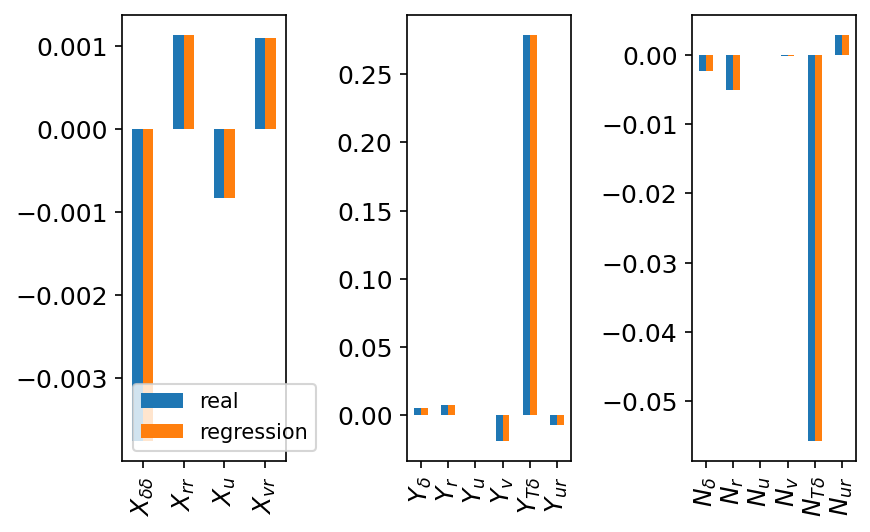

In [34]:
fig,axes=plt.subplots(ncols=3)
ax=axes[0]
df_parameters_X.plot.bar(ax=ax)
ax=axes[1]
df_parameters_Y.plot.bar(ax=ax)
ax.get_legend().set_visible(False)
ax=axes[2]
df_parameters_N.plot.bar(ax=ax)
plt.tight_layout()
ax.get_legend().set_visible(False)

glue('fig_bar_parameters', fig, display=False)


```{glue:figure} fig_bar_parameters
:figwidth: 1000px
:name: "fig_bar_parameters"

Real and regressed parameters
```